In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !rm -rf /content/drive/MyDrive/xView/images/
# !rm -rf /content/drive/MyDrive/xView/labels/
# !rm -rf /content/drive/MyDrive/xView/xView_train.geojson/

In [ ]:
RAW = "/content/drive/MyDrive/xView/xView_data/"
BASE = "/content/drive/MyDrive/xView/"

IMG_SRC = RAW + "train_images_jpg"
IMG_VAL_RAW = RAW + "val_images_jpg"
GEOJSON = RAW + "xView_train.geojson"

# YOLO folders
IMG_DIR = BASE + "images/"
LBL_DIR = BASE + "labels/"

import os
for d in [IMG_DIR+"train", IMG_DIR+"val", LBL_DIR+"train", LBL_DIR+"val"]:
    os.makedirs(d, exist_ok=True)

print("YOLO folders created")


YOLO folders created


In [ ]:
import json, numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image

LABELS_DIR = Path(BASE)/"labels/train"
LABELS_DIR.mkdir(parents=True, exist_ok=True)

xview_class2index = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, -1, 3, -1, 4, 5, 6, 7, 8, -1, 9, 10, 11,
                     12, 13, 14, 15, -1, -1, 16, 17, 18, 19, 20, 21, 22, -1, 23, 24, 25, -1, 26, 27, -1, 28, -1,
                     29, 30, 31, 32, 33, 34, 35, 36, 37, -1, 38, 39, 40, 41, 42, 43, 44, 45, -1, -1, -1, -1, 46,
                     47, 48, 49, -1, 50, 51, -1, 52, -1, -1, -1, 53, 54, -1, 55, -1, -1, 56, -1, 57, -1, 58, 59]

train_jpgs = {p.stem: p for p in Path(IMG_SRC).glob("*.jpg")}

data = json.load(open(GEOJSON))
skipped, written = 0, 0

for feat in tqdm(data["features"]):
    p = feat["properties"]
    bounds = p["bounds_imcoords"]
    img_id = p["image_id"]
    cls = int(p["type_id"])

    if not bounds or img_id is None:
        continue

    mapped = xview_class2index[cls]
    if mapped == -1:
        skipped += 1
        continue

    coords = np.array([float(x) for x in bounds.split(",")])
    if coords.size != 4:
        skipped += 1
        continue

    stem = Path(img_id).stem
    if stem not in train_jpgs:
        skipped += 1
        continue

    label_file = LABELS_DIR / f"{stem}.txt"

    img = Image.open(train_jpgs[stem])
    w, h = img.size

    x1, y1, x2, y2 = coords

    # CLIP & FIX negative
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))

    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    xc = (x1 + x2) / (2 * w)
    yc = (y1 + y2) / (2 * h)

    # Skip invalid small/negative boxes
    if bw <= 0 or bh <= 0 or xc<0 or yc<0 or xc>1 or yc>1:
        skipped += 1
        continue

    with open(label_file, "a") as f:
        f.write(f"{mapped} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

    written += 1

print(f"Written: {written}, Skipped: {skipped}")


100%|██████████| 601937/601937 [1:38:25<00:00, 101.93it/s]

✅ Done. Written: 601695, Skipped: 242


In [ ]:
import shutil, random
from pathlib import Path

all_imgs = list(Path(IMG_SRC).glob("*.jpg"))
random.shuffle(all_imgs)

val_ratio = 0.1
val_count = int(len(all_imgs) * val_ratio)

val_imgs = all_imgs[:val_count]
train_imgs = all_imgs[val_count:]

def copy_pairs(img_list, split):
    for img in img_list:
        dst_img = Path(BASE)/"images"/split/img.name

        # Copy image if not already there
        if not dst_img.exists():
            shutil.copy(img, dst_img)

        lbl = Path(BASE)/"labels"/"train"/f"{img.stem}.txt"
        dst_lbl = Path(BASE)/"labels"/split/f"{img.stem}.txt"

        # Copy label only if it exists and not already copied
        if lbl.exists() and not dst_lbl.exists():
            shutil.copy(lbl, dst_lbl)


copy_pairs(train_imgs, "train")
copy_pairs(val_imgs, "val")

print(f"Train images: {len(train_imgs)}, Val images: {len(val_imgs)}")



Train images: 762, Val images: 84


In [ ]:
data_yaml = """
path: /content/drive/MyDrive/xView/

train: images/train
val: images/val
test: xView_data/test_images_jpg

nc: 60
names: [
  "Fixed-wing Aircraft",
  "Small Aircraft",
  "Cargo Plane",
  "Helicopter",
  "Passenger Vehicle",
  "Small Car",
  "Bus",
  "Pickup Truck",
  "Utility Truck",
  "Truck",
  "Cargo Truck",
  "Truck w/Box",
  "Truck Tractor",
  "Trailer",
  "Truck w/Flatbed",
  "Truck w/Liquid",
  "Crane Truck",
  "Railway Vehicle",
  "Passenger Car",
  "Cargo Car",
  "Flat Car",
  "Tank car",
  "Locomotive",
  "Maritime Vessel",
  "Motorboat",
  "Sailboat",
  "Tugboat",
  "Barge",
  "Fishing Vessel",
  "Ferry",
  "Yacht",
  "Container Ship",
  "Oil Tanker",
  "Engineering Vehicle",
  "Tower crane",
  "Container Crane",
  "Reach Stacker",
  "Straddle Carrier",
  "Mobile Crane",
  "Dump Truck",
  "Haul Truck",
  "Scraper/Tractor",
  "Front loader/Bulldozer",
  "Excavator",
  "Cement Mixer",
  "Ground Grader",
  "Hut/Tent",
  "Shed",
  "Building",
  "Aircraft Hangar",
  "Damaged Building",
  "Facility",
  "Construction Site",
  "Vehicle Lot",
  "Helipad",
  "Storage Tank",
  "Shipping container lot",
  "Shipping Container",
  "Pylon",
  "Tower"
]
"""

with open("/content/drive/MyDrive/xView/data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml updated and saved!")


data.yaml updated and saved!


In [ ]:
!pip install ultralytics --quiet
BASE = "/content/drive/MyDrive/xView"

from ultralytics import YOLO

model = YOLO("yolov8m.pt")
model.train(
    data=f"{BASE}/data.yaml",
    epochs=175,
    imgsz=640,
    batch=4,
    workers=2
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/xView/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=175, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d36c24a9d00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0

In [ ]:
from pathlib import Path

# dataset path
BASE_DRIVE = Path("/content/drive/MyDrive/xView")

BASE_TEST_DIR = Path("/content/drive/MyDrive/xView/xView_data/test_images_jpg")

TEMP_150 = Path("/content/temp_test_150")
TEMP_150_SR = Path("/content/temp_test_150_SR")

# Output folders saved to Drive
BASELINE_OUT = Path("/content/drive/MyDrive/xView/results_no_SR")   # baseline annotated output
SR_OUT = Path("/content/drive/MyDrive/xView/results_SR")            # SR annotated output

# YOLO model path
YOLO_BEST = Path("/content/runs/detect/train/weights/best.pt")

# SR behavior
DEFAULT_SR_SCALE = 2
MAX_LONG_SIDE = 4096

# Number of images to evaluate
N_IMAGES = 150


In [ ]:
# Prepare set of 150 test images

import random, shutil, os
from pathlib import Path

random.seed(42)

TEMP_150.mkdir(parents=True, exist_ok=True)
# clear existing
for f in TEMP_150.glob("*"):
    try: f.unlink()
    except: pass

all_imgs = sorted([p for p in BASE_TEST_DIR.glob("*.jpg")])
assert len(all_imgs) >= N_IMAGES, f"Not enough images in {BASE_TEST_DIR} (need {N_IMAGES})"

selected = random.sample(all_imgs, N_IMAGES)
for p in selected:
    shutil.copy(p, TEMP_150 / p.name)

print("Selected and copied", len(selected), "images to", TEMP_150)


Selected and copied 150 images to /content/temp_test_150


In [ ]:

# Baseline inference (no SR)

from ultralytics import YOLO
from pathlib import Path

BASELINE_OUT.mkdir(parents=True, exist_ok=True)
(BASELINE_OUT / "predictions").mkdir(parents=True, exist_ok=True)

# Load model
assert YOLO_BEST.exists(), f"YOLO best.pt not found at {YOLO_BEST}. Train first."
model = YOLO(str(YOLO_BEST))

print("Running baseline inference on", len(list(TEMP_150.glob("*.jpg"))), "images...")
model.predict(
    source=str(TEMP_150),
    conf=0.20,
    imgsz=640,
    save=True,
    project=str(BASELINE_OUT),
    name="predictions",
    verbose=True
)
print("Baseline annotated outputs saved to:", BASELINE_OUT / "predictions")


Running baseline inference on 150 images...

image 1/150 /content/temp_test_150/1043.jpg: 640x640 1 Mobile Crane, 6 Buildings, 9 Construction Sites, 36.4ms
image 2/150 /content/temp_test_150/1054.jpg: 512x640 1 Bus, 293 Buildings, 3 Facilitys, 3 Vehicle Lots, 55.5ms
image 3/150 /content/temp_test_150/1069.jpg: 640x640 2 Construction Sites, 37.2ms
image 4/150 /content/temp_test_150/1075.jpg: 640x640 13 Cargo Planes, 16 Buildings, 36.4ms
image 5/150 /content/temp_test_150/108.jpg: 544x640 2 Fishing Vessels, 1 Oil Tanker, 296 Buildings, 1 Vehicle Lot, 48.8ms
image 6/150 /content/temp_test_150/1082.jpg: 640x640 299 Buildings, 1 Facility, 37.2ms
image 7/150 /content/temp_test_150/1097.jpg: 640x640 1 Barge, 36.5ms
image 8/150 /content/temp_test_150/1098.jpg: 512x640 114 Buildings, 7 Facilitys, 15 Vehicle Lots, 28.8ms
image 9/150 /content/temp_test_150/11.jpg: 448x640 298 Buildings, 1 Facility, 1 Shipping container lot, 47.2ms
image 10/150 /content/temp_test_150/1102.jpg: 512x640 1 Small Car,

In [ ]:
# SIMPLE SR (BICUBIC UPSCALE) + YOLO

import cv2, gc
from pathlib import Path
from ultralytics import YOLO

# checking folders
TEMP_150_SR.mkdir(parents=True, exist_ok=True)
SR_OUT.mkdir(parents=True, exist_ok=True)
(SR_OUT / "predictions").mkdir(parents=True, exist_ok=True)

DEFAULT_SR_SCALE = 2      # upscale x2
MAX_LONG_SIDE = 4096      # safety cap

def simple_upscale(img_bgr, scale=DEFAULT_SR_SCALE):
    h, w = img_bgr.shape[:2]
    t_w = int(w * scale)
    t_h = int(h * scale)
    long_side = max(t_w, t_h)

    # Prevent too large images
    if long_side > MAX_LONG_SIDE:
        factor = MAX_LONG_SIDE / float(max(w, h))
        t_w = max(1, int(w * factor))
        t_h = max(1, int(h * factor))

    up = cv2.resize(img_bgr, (t_w, t_h), interpolation=cv2.INTER_CUBIC)
    return up

# Load YOLO once
assert YOLO_BEST.exists(), f"YOLO best.pt missing at {YOLO_BEST}"
yolo = YOLO(str(YOLO_BEST))

# Process 150 images one by one
input_paths = sorted(list(TEMP_150.glob("*.jpg")))
print("Processing", len(input_paths), "images one-by-one (bicubic SR + YOLO)")

for i, p in enumerate(input_paths, 1):
    try:
        img = cv2.imread(str(p))
        if img is None:
            print("Cannot read", p.name)
            continue

        # Bicubic SR
        img_sr = simple_upscale(img, scale=DEFAULT_SR_SCALE)

        # Save SR image
        sr_save = TEMP_150_SR / p.name
        cv2.imwrite(str(sr_save), img_sr)

        # YOLO inference on SR image
        res = yolo.predict(source=img_sr, conf=0.20, imgsz=640, verbose=False)[0]
        out = res.plot()

        # Save annotated SR result
        out_path = SR_OUT / "predictions" / p.name
        cv2.imwrite(str(out_path), out)

        if i % 10 == 0 or i == len(input_paths):
            print(f"[{i}/{len(input_paths)}] processed, saved -> {out_path.name}")

    except Exception as ex:
        print("Error on", p.name, ":", ex)

    # cleanup
    try:
        del img, img_sr, res, out
    except:
        pass
    gc.collect()

print("SR + YOLO (bicubic) finished. SR annotated saved to:", SR_OUT / "predictions")


Showing RAW vs SR for: ['2522.jpg', '2336.jpg', '564.jpg', '299.jpg', '1054.jpg']


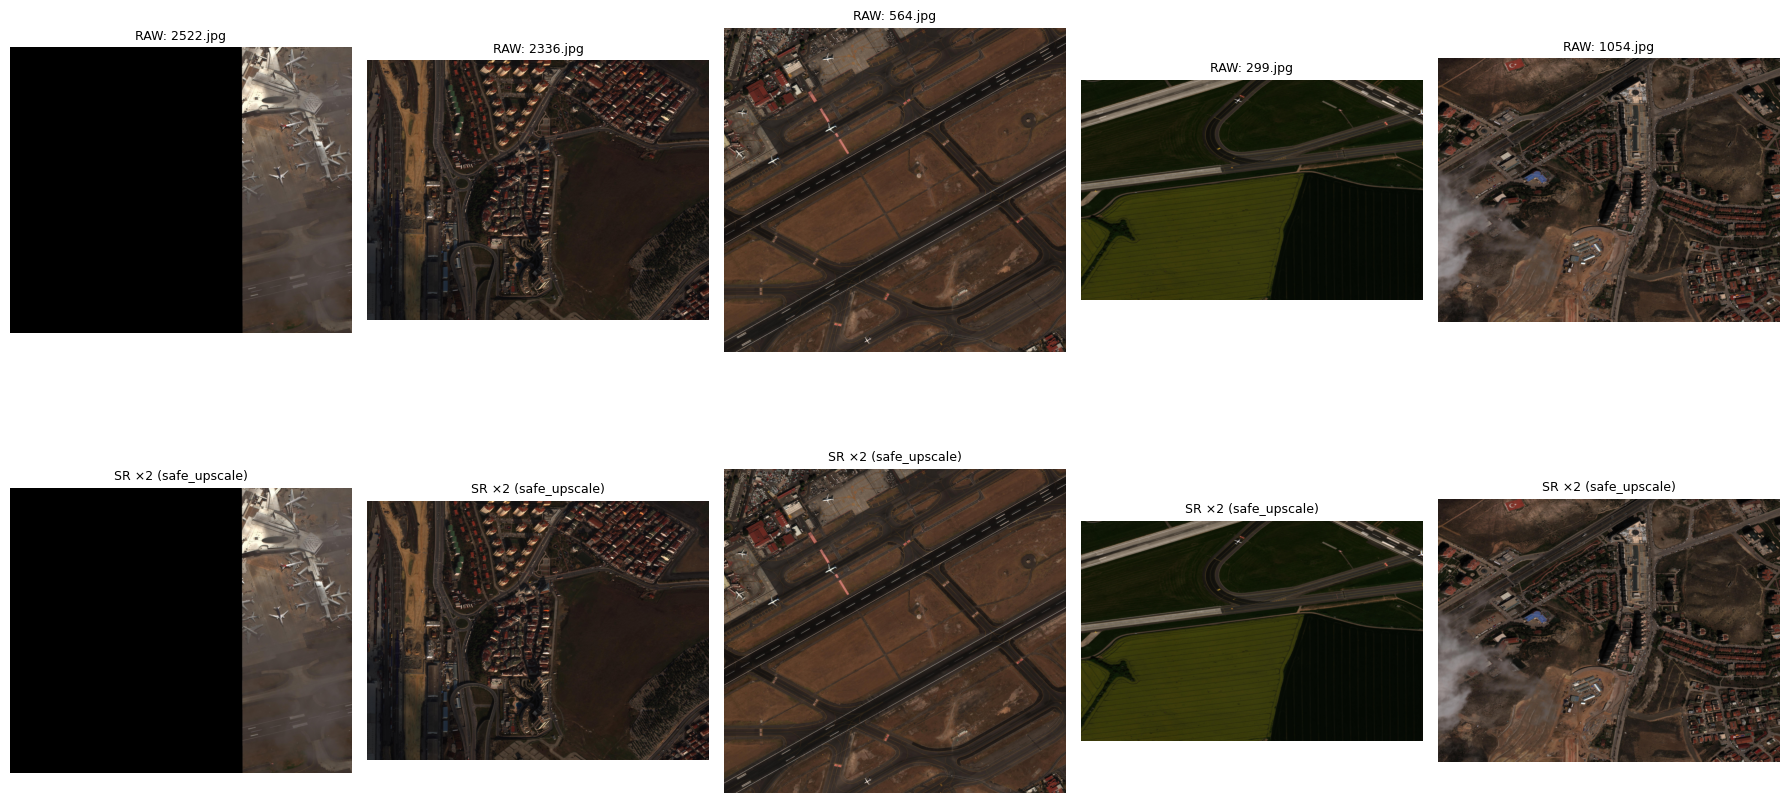

In [ ]:
# VISUALIZE: RAW TEST IMAGES vs SR IMAGES (NO DETECTIONS)

import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

TEMP_150    = Path("/content/temp_test_150")
TEMP_150_SR = Path("/content/temp_test_150_SR")

raw_imgs = sorted(TEMP_150.glob("*.jpg"))
sr_imgs  = sorted(TEMP_150_SR.glob("*.jpg"))

assert len(raw_imgs) > 0, "No raw images found in TEMP_150"
assert len(sr_imgs)  > 0, "No SR images found in TEMP_150_SR"

# pick up to 5 common filenames
common_names = list(set([p.name for p in raw_imgs]) & set([p.name for p in sr_imgs]))
sample_names = random.sample(common_names, min(5, len(common_names)))

print("Showing RAW vs SR for:", sample_names)

plt.figure(figsize=(18, 10))
for i, name in enumerate(sample_names):
    raw_path = TEMP_150 / name
    sr_path  = TEMP_150_SR / name

    raw = cv2.imread(str(raw_path))
    sr  = cv2.imread(str(sr_path))

    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    sr  = cv2.cvtColor(sr, cv2.COLOR_BGR2RGB)

    # RAW on top row
    plt.subplot(2, 5, i+1)
    plt.imshow(raw)
    plt.title(f"RAW: {name}", fontsize=9)
    plt.axis("off")

    # SR on bottom row
    plt.subplot(2, 5, i+6)
    plt.imshow(sr)
    plt.title("SR ×2 (safe_upscale)", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# PREPARE TEST DATASETS (BASELINE & SR) WITH LABELS

from pathlib import Path
import shutil
import os

BASE_DRIVE = Path("/content/drive/MyDrive/xView")
LABEL_DIR  = BASE_DRIVE / "labels/val"

TEST_BASE = Path("/content/TEST_BASELINE")
TEST_SR   = Path("/content/TEST_SR")

# Create structure: images/ + labels/
for root in [TEST_BASE, TEST_SR]:
    (root / "images").mkdir(parents=True, exist_ok=True)
    (root / "labels").mkdir(parents=True, exist_ok=True)
    # clear previous
    for f in (root/"images").glob("*"):
        f.unlink()
    for f in (root/"labels").glob("*"):
        f.unlink()

# BASELINE
for img in sorted(TEMP_150.glob("*.jpg")):
    shutil.copy(img, TEST_BASE/"images"/img.name)
    lbl_src = LABEL_DIR / f"{img.stem}.txt"
    lbl_dst = TEST_BASE/"labels"/f"{img.stem}.txt"
    if lbl_src.exists():
        shutil.copy(lbl_src, lbl_dst)
    else:
        # create empty GT to avoid YOLO crashing
        open(lbl_dst, "w").close()

# SR
for img in sorted(TEMP_150_SR.glob("*.jpg")):
    shutil.copy(img, TEST_SR/"images"/img.name)
    lbl_src = LABEL_DIR / f"{img.stem}.txt"
    lbl_dst = TEST_SR/"labels"/f"{img.stem}.txt"
    if lbl_src.exists():
        shutil.copy(lbl_src, lbl_dst)
    else:
        open(lbl_dst, "w").close()

print("TEST_BASELINE prepared at:", TEST_BASE)
print("TEST_SR prepared at      :", TEST_SR)


✔ TEST_BASELINE prepared at: /content/TEST_BASELINE
✔ TEST_SR prepared at      : /content/TEST_SR


In [ ]:
# CREATE YAML FILES FOR YOLO .val()

from pathlib import Path

BASELINE_YAML = Path("/content/baseline_test.yaml")
SR_YAML       = Path("/content/sr_test.yaml")

CLASS_NAMES = [
  "Fixed-wing Aircraft",
  "Small Aircraft",
  "Cargo Plane",
  "Helicopter",
  "Passenger Vehicle",
  "Small Car",
  "Bus",
  "Pickup Truck",
  "Utility Truck",
  "Truck",
  "Cargo Truck",
  "Truck w/Box",
  "Truck Tractor",
  "Trailer",
  "Truck w/Flatbed",
  "Truck w/Liquid",
  "Crane Truck",
  "Railway Vehicle",
  "Passenger Car",
  "Cargo Car",
  "Flat Car",
  "Tank car",
  "Locomotive",
  "Maritime Vessel",
  "Motorboat",
  "Sailboat",
  "Tugboat",
  "Barge",
  "Fishing Vessel",
  "Ferry",
  "Yacht",
  "Container Ship",
  "Oil Tanker",
  "Engineering Vehicle",
  "Tower crane",
  "Container Crane",
  "Reach Stacker",
  "Straddle Carrier",
  "Mobile Crane",
  "Dump Truck",
  "Haul Truck",
  "Scraper/Tractor",
  "Front loader/Bulldozer",
  "Excavator",
  "Cement Mixer",
  "Ground Grader",
  "Hut/Tent",
  "Shed",
  "Building",
  "Aircraft Hangar",
  "Damaged Building",
  "Facility",
  "Construction Site",
  "Vehicle Lot",
  "Helipad",
  "Storage Tank",
  "Shipping container lot",
  "Shipping Container",
  "Pylon",
  "Tower"
]

# Convert list to YAML list format
names_yaml = "\n  - ".join(CLASS_NAMES)
names_yaml = "  - " + names_yaml

baseline_yaml_str = f"""path: /content
test: {TEST_BASE.name}/images
nc: 60
names:
{names_yaml}
"""

sr_yaml_str = f"""path: /content
test: {TEST_SR.name}/images
nc: 60
names:
{names_yaml}
"""

BASELINE_YAML.write_text(baseline_yaml_str)
SR_YAML.write_text(sr_yaml_str)

print("baseline_test.yaml:", BASELINE_YAML)
print("sr_test.yaml      :", SR_YAML)


✔ baseline_test.yaml: /content/baseline_test.yaml
✔ sr_test.yaml      : /content/sr_test.yaml


Showing prediction comparison for: ['1895.jpg', '1650.jpg', '121.jpg', '882.jpg', '1358.jpg']


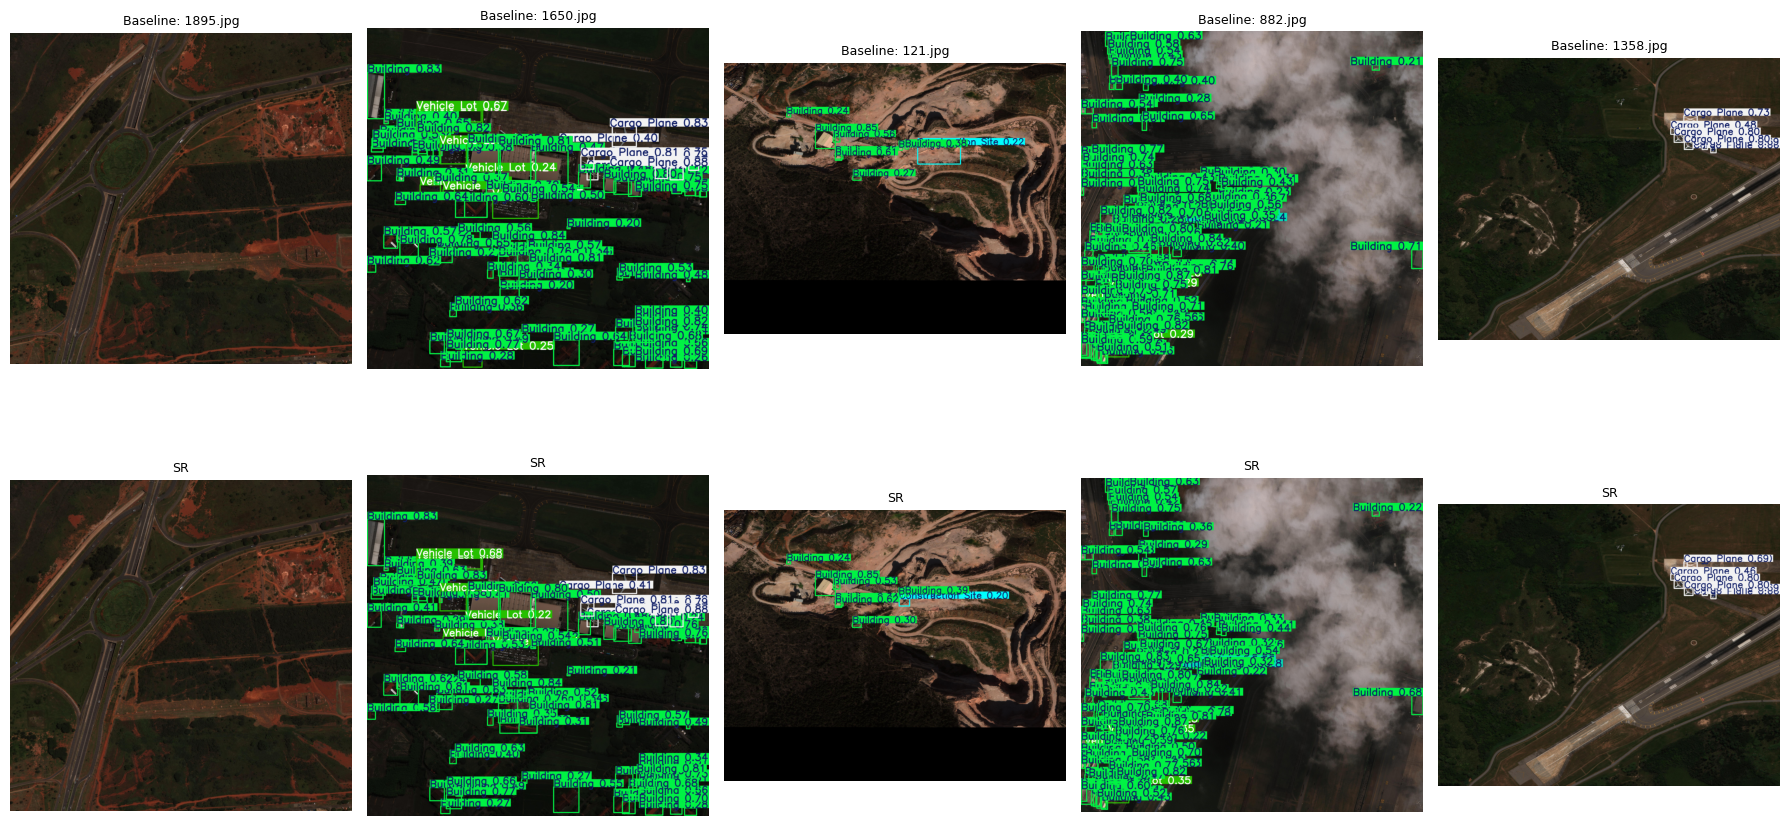

In [ ]:
# VISUALIZE: BASELINE PREDICTIONS vs SR PREDICTIONS

import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

BASELINE_PRED_DIR = BASELINE_OUT / "predictions2"
SR_PRED_DIR       = SR_OUT / "predictions"

assert BASELINE_PRED_DIR.exists(), f"{BASELINE_PRED_DIR} does not exist"
assert SR_PRED_DIR.exists(),       f"{SR_PRED_DIR} does not exist"

baseline_files = [p.name for p in BASELINE_PRED_DIR.glob("*.jpg")]
sr_files       = [p.name for p in SR_PRED_DIR.glob("*.jpg")]

common_pred = list(set(baseline_files) & set(sr_files))
assert len(common_pred) > 0, "No common predicted images between baseline and SR folders."

sample_pred = random.sample(common_pred, min(5, len(common_pred)))
print("Showing prediction comparison for:", sample_pred)

plt.figure(figsize=(18, 10))
for i, name in enumerate(sample_pred):
    b_path = BASELINE_PRED_DIR / name
    s_path = SR_PRED_DIR / name

    b_img = cv2.imread(str(b_path))
    s_img = cv2.imread(str(s_path))

    b_img = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)
    s_img = cv2.cvtColor(s_img, cv2.COLOR_BGR2RGB)

    # Baseline on top
    plt.subplot(2, 5, i+1)
    plt.imshow(b_img)
    plt.title(f"Baseline: {name}", fontsize=9)
    plt.axis("off")

    # SR on bottom
    plt.subplot(2, 5, i+6)
    plt.imshow(s_img)
    plt.title("SR", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()
